# KNN

KNN means k nearest neighbors. It is a supervised machine learning algorithm used for classification and regression. In both cases, the input consists of the k closest training examples in the feature space. When used for classification, the output is a class membership. An object is classified by a majority vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors.

At each test observation that we want to classify, we take **the class as being the class of the $k$ observations that are closest to the element to be classified**

<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/KNN_final1_ibdm8a.png" width=600>

This algorithm is very simple and intuitive, but there are two elements of extreme importance:

> How to measure the **distance** between data? What is the **metric**?

It will be seen that sklearn allows us to choose different distance metrics, such as the Euclidean distance, the Manhattan distance, the Minkowski distance, etc.

> What is the appropriate number of neighbors: i.e., **how to choose $k$?**

This is a particularly important choice, as different choices of $k$ can easily lead to different classifications:

<img src="https://helloacm.com/wp-content/uploads/2016/03/2012-10-26-knn-concept.png" width=400>

If: 
- $k=1$ : high variance (overfitting)
- $k=N$ : high bias (underfitting)

It can be said that KNN is a lazy learner, because there is no explicit training step. The training step is the data itself.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Reading the dataset

As an example we will use breast cancer data, available at [UCI](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) or by [kaggle](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data). The idea is that we can build a model to classify, based on physiological measures, whether a tumor is malignant or benign.

In [2]:
df = pd.read_csv("../data/breast-cancer.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
# the ID column can be dropped
df = df.drop(columns="id")

In [4]:
# it can be seen that there is a lot of difference in scale in the features. It is necessary to normalize.
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [5]:
df["diagnosis"].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

There is a slight imbalance: there is more data from benign tumors than malignant ones. Since the imbalance is not so blatant (80-20), and this imbalance is something natural, we will not treat this case, we will leave it to treat a more critical case.

[Click here](https://machinelearningmastery.com/what-is-imbalanced-classification/) to learn more about class imbalance; and [here](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) if you want to know some ways to address this problem (spoiler alert).

One important thing is to always set the `stratify` parameter of the train-test split, which will guarantee the same distribution of the target in both the training and test sets. This makes the difference in distribution an additional factor of bias in the model evaluation.

In [6]:
X = df.drop(columns="diagnosis")
y = df["diagnosis"]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)

In [8]:
y.value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

In [9]:
y_train.value_counts(normalize=True)

B    0.626374
M    0.373626
Name: diagnosis, dtype: float64

In [10]:
y_test.value_counts(normalize=True)

B    0.631579
M    0.368421
Name: diagnosis, dtype: float64

## Transforming the data

The first process that can be done for KNN tuning is **feature transformation**. Due to KNN using **distances** as a criterion for classification, having the variables transformed ensures that biases related to the scale of the data are eliminated. To **normalize the data**, sklearn presents us with the [standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) tool.

It is **very important** that transformers are fitted **with training data**, so that information from the test base is not used in training (a concept known as [data leakage](https://machinelearningmastery.com/data-preparation-without-data-leakage/)).

In the case of the standard scaler: the objective of `.fit()` is to determine the mean $\mu$ and standard deviation $\sigma$ of the data, so that normalization is done. If we calculate these parameters using **all the data**, we are using information from the test base. Therefore, always follow the following step-by-step for applying transformers:

- first, do the train test split
- use the `.fit()` on the **train** data
- use the `.transform()` to transform the training and test data

In [11]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

In [12]:
pd.DataFrame(X_train_ss, columns=X_train.columns).describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,...,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,0.0
mean,-1.737316e-16,3.904081e-16,4.704418e-16,-1.171224e-16,7.242070e-16,-5.075305e-17,-4.489693e-17,2.928061e-17,2.342449e-17,3.669836e-16,...,2.186285e-16,-2.986622e-16,-1.561632e-17,-1.522592e-16,-1.132183e-16,-4.489693e-17,3.025663e-17,-4.841060e-16,3.006142e-16,NaN
std,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,...,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,NaN
min,-2.009730e+00,-2.265011e+00,-1.961360e+00,-1.433461e+00,-2.342455e+00,-1.568307e+00,-1.092835e+00,-1.236420e+00,-2.733834e+00,-1.791603e+00,...,-2.286387e+00,-1.682868e+00,-1.212587e+00,-2.596976e+00,-1.442492e+00,-1.298977e+00,-1.729670e+00,-2.141576e+00,-1.602524e+00,NaN
25%,-6.869865e-01,-7.192578e-01,-6.877646e-01,-6.643427e-01,-7.599676e-01,-7.446452e-01,-7.311067e-01,-7.398554e-01,-7.042022e-01,-7.295506e-01,...,-7.269867e-01,-6.949785e-01,-6.436573e-01,-7.475060e-01,-6.811748e-01,-7.355618e-01,-7.700379e-01,-6.377821e-01,-7.030095e-01,NaN
50%,-2.310610e-01,-1.207886e-01,-2.444667e-01,-3.143644e-01,-5.267576e-02,-2.145711e-01,-3.649669e-01,-3.954004e-01,-5.783428e-02,-2.031921e-01,...,-6.996374e-02,-2.990905e-01,-3.561409e-01,-4.191078e-02,-2.454053e-01,-2.141609e-01,-2.170230e-01,-1.439281e-01,-2.222582e-01,NaN
75%,4.947835e-01,5.628428e-01,4.975359e-01,3.775369e-01,6.231343e-01,4.923801e-01,5.271006e-01,6.321626e-01,5.034376e-01,5.249492e-01,...,7.072664e-01,5.606441e-01,3.987080e-01,6.189186e-01,5.218523e-01,5.217957e-01,6.980537e-01,4.340876e-01,4.386715e-01,NaN
max,3.900239e+00,4.634299e+00,3.899731e+00,5.114742e+00,4.715773e+00,4.485809e+00,4.137033e+00,3.838961e+00,4.435961e+00,4.987148e+00,...,3.891934e+00,4.198771e+00,5.782013e+00,3.859114e+00,5.071677e+00,4.611335e+00,2.628551e+00,5.914120e+00,6.798089e+00,NaN


Another option would be to transform the data with the [min max scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - **leaving the sample space between 0 and 1**.

In [13]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

Or even the [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html):

In [14]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler().fit(X_train)

X_train_rs = rs.transform(X_train)
X_test_rs = rs.transform(X_test)

Now, we are ready to train and evaluate the model, with the scaled features.

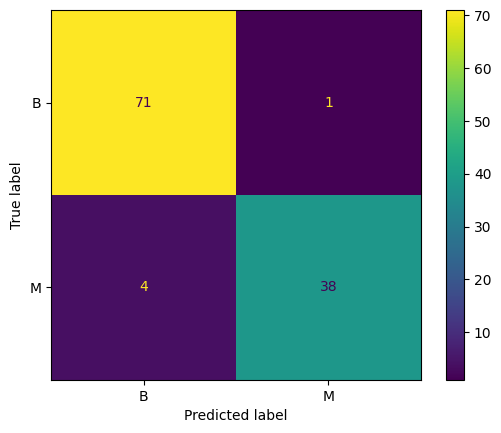

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114





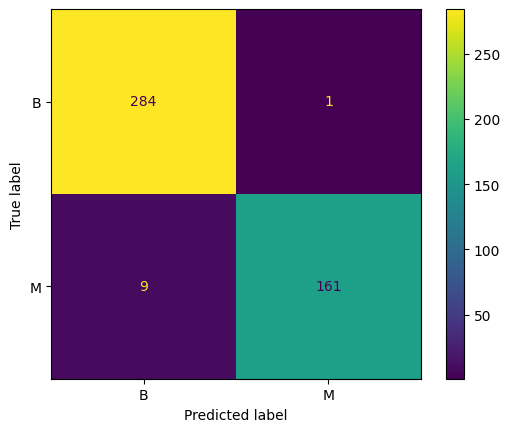

              precision    recall  f1-score   support

           B       0.97      1.00      0.98       285
           M       0.99      0.95      0.97       170

    accuracy                           0.98       455
   macro avg       0.98      0.97      0.98       455
weighted avg       0.98      0.98      0.98       455



In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ====================

df = pd.read_csv("../data/breast-cancer.csv")
X = df.drop(columns=["id", "diagnosis", "Unnamed: 32"])
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

knn = KNeighborsClassifier().fit(X_train_ss, y_train)

# ====================

y_pred_test = knn.predict(X_test_ss)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

print("\n======================================================================\n")

y_pred_train = knn.predict(X_train_ss)

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

Step-by-step of the classification process:

In [16]:
# first test observation
X_test_ss[0]

array([-0.77089916, -2.00602473, -0.76451652, -0.71183971, -0.1583148 ,
       -0.68680034, -0.66248612, -0.57475415, -0.53582061, -0.22760708,
       -0.93280815, -1.37244026, -0.85278289, -0.6368401 , -0.2999339 ,
       -0.56993036, -0.53250895, -0.83258923, -0.8416237 , -0.59337276,
       -0.72135781, -1.63595077, -0.70654903, -0.65337009,  0.96851866,
       -0.10446758, -0.30668651, -0.38805702,  0.16254727,  0.06095804])

In [17]:
# prediction for the first test observation
knn.predict(X_test_ss[0].reshape(1, -1))

array(['B'], dtype=object)

In [18]:
# k nearest neighbors of the first test observation
n = knn.kneighbors(X_test_ss[0].reshape(1, -1))[1]
n

array([[236, 428, 164,  34,  98]])

In [19]:
# classification of the k nearest neighbors of the first test observation
y_train.iloc[n[0]]

271    B
527    B
48     B
390    B
158    B
Name: diagnosis, dtype: object

Let's also perform cross-validation.

The original classes can be used to evaluate the final model with the confusion matrix or the `classification_report`. But, to use `cross_validate`, it is necessary to explicitly indicate it. To do this, there are two options:

- 1 - perform the mapping explicitly and then use the code exactly as above
- 2- indicate which is the positive class (value 1) when indicating the metric to be calculated - but for this, the respective function of the metric must be used, together with the `pos_label` argument

Let's check both options:

In [20]:
y.map({"M":1, "B":0})

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

In [21]:
from sklearn.model_selection import cross_validate, KFold

df = pd.read_csv("../data/breast-cancer.csv")

X = df.drop(columns=["id", "diagnosis", "Unnamed: 32"])
y = df["diagnosis"]

# ====================

# change the target
y_num = y.map({"M":1, "B":0})

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y_num, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

estimator = KNeighborsClassifier()

# ====================

group = KFold(n_splits=10, shuffle=True, random_state=42)

metrics = "f1"

results = cross_validate(estimator=estimator,
                         X=X_train_ss, y=y_train,
                         cv=group,
                         scoring=metrics,
                         return_train_score=True)

pd.DataFrame(results)

,fit_time,score_time,test_score,train_score
0,0.000208,0.001506,0.947368,0.971246
1,0.000329,0.001479,0.977778,0.972222
2,0.000250,0.001476,0.974359,0.969283
3,0.000262,0.001743,0.971429,0.962712
4,0.000255,0.001432,0.952381,0.971061
5,0.000268,0.003343,0.974359,0.962199
6,0.000256,0.002113,0.947368,0.969283
7,0.000262,0.002025,0.937500,0.962963
8,0.000273,0.001977,0.818182,0.974026
9,0.000265,0.003049,0.972973,0.962457


Second way, just indicating what is the positive class:

In [22]:
df = pd.read_csv("../data/breast-cancer.csv")

X = df.drop(columns=["id", "diagnosis", "Unnamed: 32"])
y = df["diagnosis"]

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

estimator = KNeighborsClassifier()

# ====================

group = KFold(n_splits=10, shuffle=True, random_state=42)


from sklearn.metrics import make_scorer, f1_score

metrics = make_scorer(f1_score, pos_label="M")

results = cross_validate(estimator=estimator,
                         X=X_train_ss, y=y_train,
                         cv=group,
                         scoring=metrics,
                         return_train_score=True)

pd.DataFrame(results)

,fit_time,score_time,test_score,train_score
0,0.000365,0.021937,0.947368,0.971246
1,0.000380,0.013391,0.977778,0.972222
2,0.000619,0.002169,0.974359,0.969283
3,0.000447,0.011279,0.971429,0.962712
4,0.000365,0.001349,0.952381,0.971061
5,0.000350,0.001240,0.974359,0.962199
6,0.000296,0.001081,0.947368,0.969283
7,0.000333,0.001213,0.937500,0.962963
8,0.000292,0.001169,0.818182,0.974026
9,0.000295,0.001298,0.972973,0.962457


We have discussed that the recall of the "M" class is what we want to optimize. So, first of all, let's do the CV for this metric:

In [23]:
df = pd.read_csv("../data/breast-cancer.csv")

X = df.drop(columns=["id", "diagnosis", "Unnamed: 32"])
y = df["diagnosis"]

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

estimator = KNeighborsClassifier()

# ====================

group = KFold(n_splits=10, shuffle=True, random_state=42)

from sklearn.metrics import make_scorer, recall_score

metrics = make_scorer(recall_score, pos_label="M")

results = cross_validate(estimator=estimator,
                         X=X_train_ss, y=y_train,
                         cv=group,
                         scoring=metrics,
                         return_train_score=True)

pd.DataFrame(results)

,fit_time,score_time,test_score,train_score
0,0.000379,0.001759,0.900000,0.950000
1,0.000377,0.001566,0.956522,0.952381
2,0.000357,0.001276,0.950000,0.946667
3,0.000303,0.001296,0.944444,0.934211
4,0.000323,0.001232,0.909091,0.949686
5,0.000294,0.001207,0.950000,0.933333
6,0.000307,0.001636,0.900000,0.946667
7,0.000294,0.001162,0.882353,0.934641
8,0.000329,0.001217,0.750000,0.949367
9,0.000298,0.001173,0.947368,0.933775


The model performed well, but it can be improved.  The cycle of improvements will be started to see if we can improve the model performance, in a process that is often called **tunning**.

**Remember:** train the scalers **only on the training data** to avoid information from the test data being passed to the scaler. (More information [here](https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data))

# Special tools

## Pipeline

The [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) is a structure that sklearn provides in order to ensure that we can in a single structure pass **the estimator and the transformer** (and many other things). For more information, [click here](https://scikit-learn.org/stable/modules/compose.html#pipeline).

In [24]:
from sklearn.pipeline import Pipeline

**Standard train-test split**

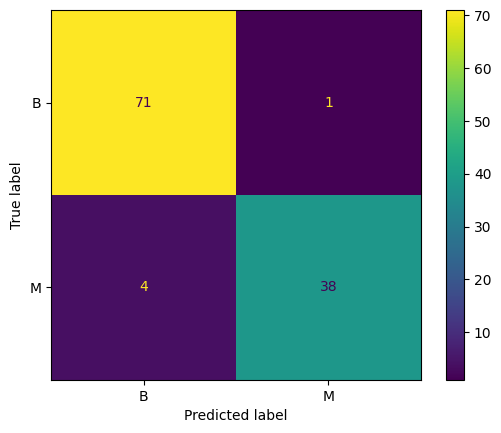

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


# ====================



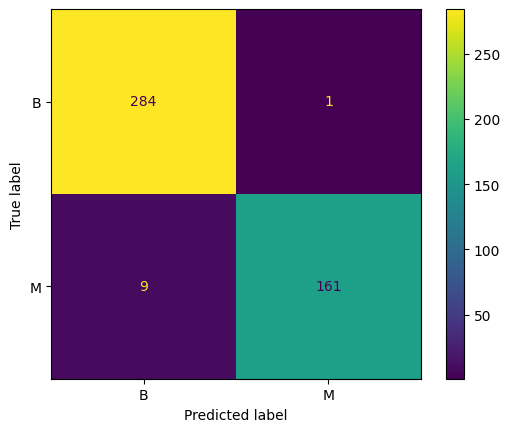

              precision    recall  f1-score   support

           B       0.97      1.00      0.98       285
           M       0.99      0.95      0.97       170

    accuracy                           0.98       455
   macro avg       0.98      0.97      0.98       455
weighted avg       0.98      0.98      0.98       455



In [25]:
df = pd.read_csv("../data/breast-cancer.csv")

X = df.drop(columns=["id", "diagnosis", "Unnamed: 32"])
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

# arg: an array of tuples of the type [("name of the structure", instantiated class of the structure)]
transforms = [("std_scaler", StandardScaler()), 
              ("knn", KNeighborsClassifier(n_neighbors=5))]

pipe = Pipeline(transforms).fit(X_train, y_train)

# ====================

y_pred_test = pipe.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

print("\n# ====================\n")

y_pred_train = pipe.predict(X_train)

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

**Cross-validation**

In [26]:
df = pd.read_csv("../data/breast-cancer.csv")

X = df.drop(columns=["id", "diagnosis", "Unnamed: 32"])
y = df["diagnosis"]

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

transforms = [("std_scaler", StandardScaler()), 
                ("knn", KNeighborsClassifier(n_neighbors=5))]

pipe = Pipeline(transforms)

# ====================

group = KFold(n_splits=10, shuffle=True, random_state=42)

metrics = make_scorer(recall_score, pos_label="M")

results = cross_validate(estimator=pipe,
                         X=X_train, y=y_train,
                         cv=group,
                         scoring=metrics,
                         return_train_score=True)

pd.DataFrame(results)

,fit_time,score_time,test_score,train_score
0,0.001502,0.003669,0.900000,0.950000
1,0.001561,0.002890,0.956522,0.952381
2,0.001397,0.001641,0.950000,0.946667
3,0.001435,0.001803,0.944444,0.934211
4,0.001303,0.001872,0.909091,0.949686
5,0.001470,0.001836,0.950000,0.933333
6,0.001817,0.001855,0.900000,0.946667
7,0.001405,0.001760,0.882353,0.934641
8,0.001481,0.001799,0.750000,0.949367
9,0.001544,0.003033,0.947368,0.933775


A good idea is to use the [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html), as it maintains the stratification of the target within each split. This is especially important for unbalanced data (in the target).

In [27]:
from sklearn.model_selection import StratifiedKFold

In [28]:
df = pd.read_csv("../data/breast-cancer.csv")

X = df.drop(columns=["id", "diagnosis", "Unnamed: 32"])
y = df["diagnosis"]

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

transforms = [("std_scaler", StandardScaler()), 
                ("knn", KNeighborsClassifier(n_neighbors=5))]

pipe = Pipeline(transforms)

# ====================

group = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrics = make_scorer(recall_score, pos_label="M")

results = cross_validate(estimator=pipe,
                         X=X_train, y=y_train,
                         cv=group,
                         scoring=metrics,
                         return_train_score=True)

pd.DataFrame(results)

,fit_time,score_time,test_score,train_score
0,0.001522,0.003564,1.000000,0.934641
1,0.002038,0.003179,0.823529,0.960784
2,0.001565,0.002447,0.941176,0.947712
3,0.001680,0.002844,1.000000,0.941176
4,0.001866,0.003320,0.882353,0.947712
5,0.001433,0.002260,0.823529,0.947712
6,0.001448,0.001914,0.705882,0.954248
7,0.001784,0.001875,1.000000,0.934641
8,0.001389,0.001682,0.941176,0.934641
9,0.001652,0.002086,0.941176,0.941176


## Gridsearch

The [Gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) is a structure that sklearn provides so that **the exhaustive search for hyperparameters of an estimator** can be done. In practice, what the gridsearch does is **train several models with different combinations of hyperparameters**, in order to keep the best of them as the final model. All we need to do is indicate which hyperparameters we want to search for: the **grid**.

<img src="https://www.yourdatateacher.com/wp-content/uploads/2021/03/image-6.png" width=500>

It is also very common to pass the **Pipeline** as an argument to the gridsearch. For more information, [click here](https://scikit-learn.org/stable/modules/grid_search.html#grid-search).

The Gridsearch evaluates the best model according to the metric we pass in `scoring`. [Click here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) to see the metrics available by default. The metric is calculated several times, according to the `cv` parameter. In the end, the best model is the one with the best **average** scoring among the cross validated scores.

<img src="https://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png" width=600> 

By performing cross-validation, we guarantee a fair evaluation of each of the candidate models (each built with a different combination of hyperparameters). This way, we know that the best combination of hyperparameters to be found will not be in any way "overfit" on particularities of the training base.


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [30]:
df = pd.read_csv("../data/breast-cancer.csv")

X = df.drop(columns=["id", "diagnosis", "Unnamed: 32"])
y = df["diagnosis"]

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

transforms = [("std_scaler", StandardScaler()), 
                ("knn", KNeighborsClassifier())]
pipe = Pipeline(transforms)

# ====================

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
metrics = make_scorer(recall_score, pos_label="M")

# ====================

param_grid = {"knn__weights" : ["uniform", "distance"],
              "knn__metric" : ["manhattan", "euclidean"],
              "knn__n_neighbors" : range(2, 21)}

grid_knn = GridSearchCV(estimator=pipe, 
                        param_grid=param_grid,
                        scoring=metrics,
                        cv=splitter)

grid_knn.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(2, 21),
                         'knn__weights': ['uniform', 'distance']},
             scoring=make_scorer(recall_score, pos_label=M))

`.best_estimator_`: returns which Pipeline choices produced the best model. With regard to the model, we have exactly which parameters were chosen.

`.best_params_`: returns the best parameters for the model.

`.best_score_`: returns the **cross-validated average of the metric of interest** of the best model. As this is the average value built using CV, this is statistically the most realistic value to be assigned to the model's performance.

`.cv_results_`: returns a dictionary with all the results of the cross-validation. It is a very rich dictionary, with a lot of information. It is worth taking a look at the documentation to understand what each of the keys means.

In [31]:
grid_knn.best_estimator_

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=3))])

In [32]:
grid_knn.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}

In [33]:
grid_knn.best_score_

0.9411764705882353

In [34]:
grid_knn.cv_results_

{'mean_fit_time': array([0.0016588 , 0.00141008, 0.00140848, 0.00145032, 0.00138171,
        0.00141532, 0.0014806 , 0.0014138 , 0.00137136, 0.00143197,
        0.00139635, 0.00143738, 0.00138886, 0.00137596, 0.00139089,
        0.00134964, 0.00135787, 0.00133953, 0.00143673, 0.00141852,
        0.00140841, 0.00146399, 0.00150561, 0.00158782, 0.00163743,
        0.00148215, 0.00143971, 0.0014333 , 0.0014297 , 0.00141449,
        0.00143085, 0.00149295, 0.00159967, 0.00144527, 0.00141823,
        0.00136461, 0.0013278 , 0.00128722, 0.00130155, 0.0013773 ,
        0.00139647, 0.00139313, 0.00136726, 0.00141168, 0.00151291,
        0.00141947, 0.0013998 , 0.00155516, 0.00148201, 0.00137479,
        0.00142841, 0.0015378 , 0.00137169, 0.00137043, 0.00135767,
        0.00145311, 0.00139973, 0.00130465, 0.00128849, 0.00134861,
        0.00137322, 0.00135846, 0.00140131, 0.00138581, 0.00154414,
        0.00139663, 0.00137949, 0.00144324, 0.00135615, 0.00151606,
        0.00139182, 0.00134211,

Now, using two metrics:

In [35]:
df = pd.read_csv("../data/breast-cancer.csv")

X = df.drop(columns=["id", "diagnosis", "Unnamed: 32"])
y = df["diagnosis"]

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

transforms = [("std_scaler", StandardScaler()), 
                ("knn", KNeighborsClassifier())]

pipe = Pipeline(transforms)

# ====================

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
metric1 = make_scorer(recall_score, pos_label="M")
metric2 = make_scorer(f1_score, pos_label="M")

# ====================

param_grid = {"knn__weights" : ["uniform", "distance"],
              "knn__metric" : ["manhattan", "euclidean"],
              "knn__n_neighbors" : range(2, 21)}

grid_knn = GridSearchCV(estimator=pipe, 
                        param_grid=param_grid,
                        scoring={"recall": metric1, "f1" : metric2},
                        cv=splitter,
                        refit="f1")

grid_knn.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(2, 21),
                         'knn__weights': ['uniform', 'distance']},
             refit='f1',
             scoring={'f1': make_scorer(f1_score, pos_label=M),
                      'recall': make_scorer(recall_score, pos_label=M)})

# KNN for regression

The idea of KNN is very simple: the target assigned to a new observation is equal to the **average of the target of the $k$ closest observations**

<img src="https://bookdown.org/f100441618/bookdown-regresion/www/KNN.jpg" width=500>

Naturally, also for regression the parameter $k$ and the distance metric are important hyperparameters:

<img src="https://i.stack.imgur.com/gAILq.png" width=500>

The SKLearn class is [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html). Take a look at the User Guide and also at the [RadiusNeighborsRegressor!](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsRegressor.html#sklearn.neighbors.RadiusNeighborsRegressor)

In [36]:
from sklearn.neighbors import KNeighborsRegressor

In [37]:
df_houses = pd.read_csv("../data/house-prices.csv")
df_houses = df_houses.select_dtypes(include=np.number).dropna()

X = df_houses.drop(columns=["Id", "SalePrice"])
y = df_houses["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [38]:
transforms = [("std_scaler", StandardScaler()), 
              ("knn", KNeighborsRegressor())]

pipe = Pipeline(transforms)

# ====================

splitter = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = "neg_mean_absolute_error"

# ====================

param_grid = {"knn__weights" : ["uniform", "distance"],
              "knn__metric" : ["manhattan", "euclidean"],
              "knn__n_neighbors" : range(2, 21)}

grid_knn_reg = GridSearchCV(estimator=pipe, 
                            param_grid=param_grid,
                            scoring=metrics,
                            cv=splitter)

grid_knn_reg.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(2, 21),
                         'knn__weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error')

In [39]:
grid_knn_reg.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 8, 'knn__weights': 'distance'}

In [40]:
grid_knn_reg.best_score_

-20297.192189179004

In [41]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred_train = grid_knn_reg.predict(X_train)
print("\nTrain metrics:\n")
print(f"R^2: {r2_score(y_train, y_pred_train):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")

y_pred_test = grid_knn_reg.predict(X_test)
print("\nTest metrics:\n")
print(f"R^2: {r2_score(y_test, y_pred_test):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}") 


Train metrics:

R^2: 1.00
MAE: 0.00
RMSE: 0.00

Test metrics:

R^2: 0.81
MAE: 20875.14
RMSE: 38970.95


Limiting k, to avoid overfitting:

In [42]:
transforms = [("std_scaler", StandardScaler()), 
              ("knn", KNeighborsRegressor())]

pipe = Pipeline(transforms)

# ====================

splitter = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = "neg_mean_absolute_error"

# ====================

param_grid = {"knn__weights" : ["uniform"],
              "knn__metric" : ["manhattan", "euclidean"],
              "knn__n_neighbors" : range(50, 100)}

grid_knn_reg = GridSearchCV(estimator=pipe, 
                            param_grid=param_grid,
                            scoring=metrics,
                            cv=splitter)

grid_knn_reg.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(50, 100),
                         'knn__weights': ['uniform']},
             scoring='neg_mean_absolute_error')

In [43]:
y_pred_train = grid_knn_reg.predict(X_train)
print("\nTrain metrics:\n")
print(f"R^2: {r2_score(y_train, y_pred_train):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")

y_pred_test = grid_knn_reg.predict(X_test)
print("\nTest metrics:\n")
print(f"R^2: {r2_score(y_test, y_pred_test):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}") 


Train metrics:

R^2: 0.77
MAE: 22564.92
RMSE: 38739.83

Test metrics:

R^2: 0.70
MAE: 24995.13
RMSE: 48348.02
